In [2]:
from scipy.io import arff
import pandas as pd
import numpy as np

In [4]:
data = arff.loadarff('4year.arff')
df = pd.DataFrame(data[0])

In [5]:
df['bankruptcy'] = (df['class']==b'1')
df.drop(columns=['class'], inplace=True)
df.columns = ['X{0:02d}'.format(k) for k in range(1,65)] + ['bankruptcy']

In [6]:
df.fillna(df.mean(), inplace=True)
df.isna().sum()
X_imp = df.values

In [7]:
from sklearn.model_selection import train_test_split

X, y = X_imp[:, :-1], X_imp[:, -1]

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In [8]:
import sklearn.preprocessing as skpre

stdsc = skpre.StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
print(X_train_std.shape)
X_test_std = stdsc.transform(X_test)
print(X_test_std.shape)

F:\aconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(6854, 64)
(2938, 64)


### Find the 2 most important features

using Logistic Regression with L1 penalty

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# and put more...

In [10]:
lr = LogisticRegression(C=0.01, random_state=0,penalty='l1') # complete
lr.fit(X_train_std, y_train.astype(int))

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
lr.coef_[lr.coef_!=0].shape # check the number of the features with non-zero weights

(2,)

In [12]:
# redefine X_train_std and X_test_std
X_train_std = X_train_std[:, lr.coef_[0]!=0]
X_test_std = X_test_std[:, lr.coef_[0]!=0]

### Apply LR / SVM / Decision Tree below¶

In [13]:
lr = LogisticRegression(penalty='l1')
lr.fit(X_train_std, y_train.astype(int))

print('Training accuracy:', lr.score(X_train_std, y_train.astype(int)))
print('Test accuracy:', lr.score(X_test_std, y_test.astype(int)))

Training accuracy: 0.946892325649256
Test accuracy: 0.9469026548672567


In [14]:
## SVM
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=0)
svm.fit(X_train_std, y_train.astype(int))
print('Training accuracy:', svm.score(X_train_std, y_train.astype(int)))
print('Test accuracy:', svm.score(X_test_std, y_test.astype(int)))

Training accuracy: 0.9474759264662971
Test accuracy: 0.9472430224642614


In [15]:
## Decision Tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)
tree.fit(X_train_std, y_train.astype(int))
print('Training accuracy:', tree.score(X_train_std, y_train.astype(int)))
print('Test accuracy:', tree.score(X_test_std, y_test.astype(int)))

Training accuracy: 0.9476218266705574
Test accuracy: 0.9469026548672567


### Visualize the classification

In [16]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

### The result of the LR:

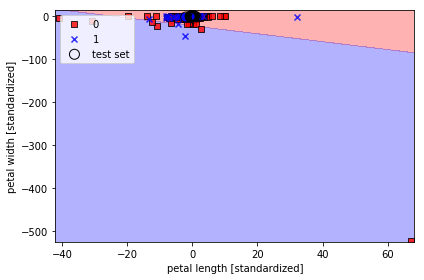

In [17]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train.astype(int), y_test.astype(int)))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=lr, test_idx=range(0, 50))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()

### The result of the SVM:

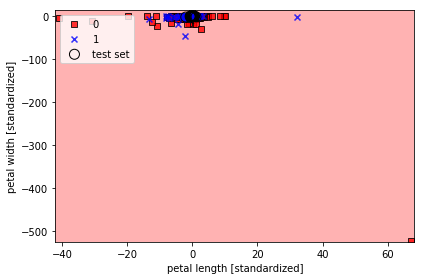

In [18]:
#X_combined_std = np.vstack((X_train_std, X_test_std))
#y_combined = np.hstack((y_train.astype(int), y_test.astype(int)))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=svm, test_idx=range(0, 50))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()

### The result of the decision tree:

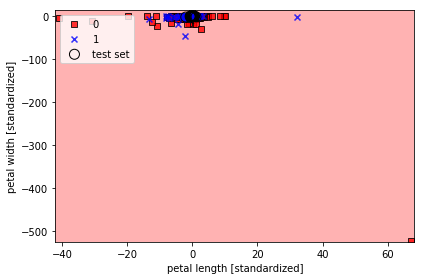

In [19]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train.astype(int), y_test.astype(int)))

plot_decision_regions(X=X_combined_std, y=y_combined,
                      classifier=tree, test_idx=range(0, 50))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/03_01.png', dpi=300)
plt.show()